# <img src="https://filoger.com/wp-content/uploads/2021/09/circle-logo-1536x1536.png" alt="keras" width="150" height="150">
<h1 align=center><font size = 7>Lab 09 : SVM</font></h1>
<h1 align=center><font size = 4>Hands-On Machine Learning, 1401 | DeadLine: 8th Azar, 13:00 </font></h1>



### Linear Kernel:
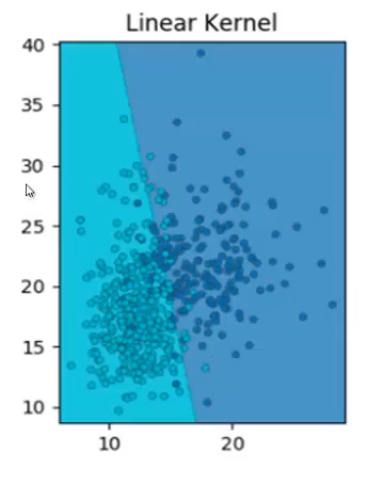

### Gaussian / RBF kernel:
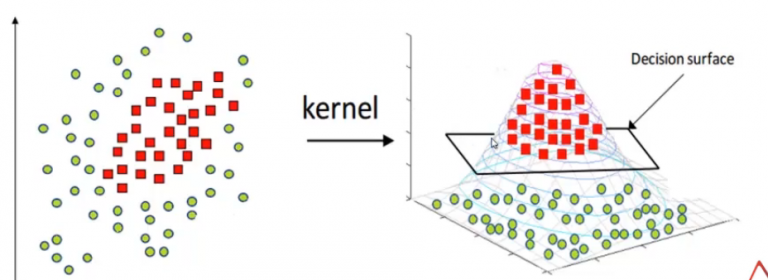

### Polynomial kernel:
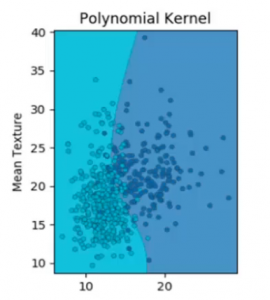

* But the problem with the polynomial kernel is, the number of higher dimension features increases exponentially. As a result, this is computationally more expensive than RBF or linear kernel.

# 0. Import libraries

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# 1.Import dataset

In [2]:
diabetes_df = pd.read_csv('diabetes.csv')

In [3]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [12]:
for col in diabetes_df.columns:
    print(f'{col}:')
    print(f'Min: {diabetes_df[col].min()}, Max: {diabetes_df[col].max()}')

Pregnancies:
Min: 0, Max: 17
Glucose:
Min: 0, Max: 199
BloodPressure:
Min: 0, Max: 122
SkinThickness:
Min: 0, Max: 99
Insulin:
Min: 0, Max: 846
BMI:
Min: 0.0, Max: 67.1
DiabetesPedigreeFunction:
Min: 0.078, Max: 2.42
Age:
Min: 21, Max: 81
Outcome:
Min: 0, Max: 1


In this particular dataset all the missing values were given the 0 as a value which is not good for the authenticity of the dataset. Hence we will first replace the 0 value with the NAN value then start the imputation process.

In [13]:
diabetes_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = diabetes_df[['Glucose', 
                            'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [14]:
diabetes_df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [15]:
diabetes_df.duplicated().sum()

0

In [16]:
def missing_percent(df):
    
    nan_percent = 100 * (df.isnull().sum() / len(df))
    nan_percent = nan_percent[nan_percent > 0].sort_values()
    
    return nan_percent

In [17]:
def missing_plot(df):
    
    nan_percent = missing_percent(df)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=nan_percent.index, y=nan_percent)

In [18]:
missing_percent(diabetes_df)

Glucose           0.651042
BMI               1.432292
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
dtype: float64

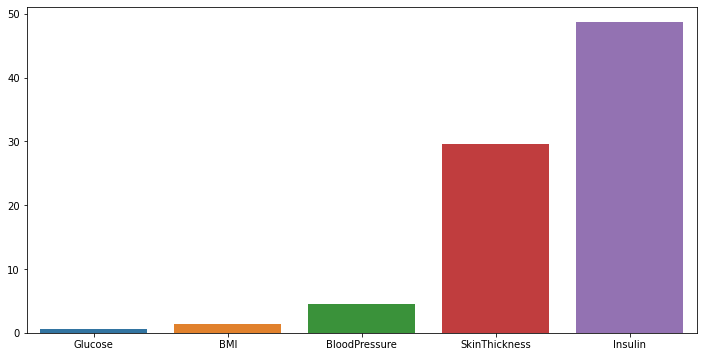

In [19]:
missing_plot(diabetes_df)

* If only a few rows are missing some values, then it might just be a good idea to drop those rows.
* We choose a threshold of 1%. It means, if there is less than 1% of a feature are missing,then we will consider just dropping that rows.

In [20]:
nan_percent = missing_percent(diabetes_df)
nan_percent[nan_percent<1]

Glucose    0.651042
dtype: float64

In [21]:
diabetes_df[diabetes_df['Glucose'].isnull()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,NaN,48.0,20.0,NaN,24.7,0.140,22,0
182,1,NaN,74.0,20.0,23.0,27.7,0.299,21,0
342,1,NaN,68.0,35.0,NaN,32.0,0.389,22,0
349,5,NaN,80.0,32.0,NaN,41.0,0.346,37,1
502,6,NaN,68.0,41.0,NaN,39.0,0.727,41,1


### Dropping Rows:

In [22]:
diabetes_df = diabetes_df.dropna(axis=0, subset=['Glucose'])

In [23]:
missing_percent(diabetes_df)

BMI               1.441678
BloodPressure     4.587156
SkinThickness    29.750983
Insulin          48.492792
dtype: float64

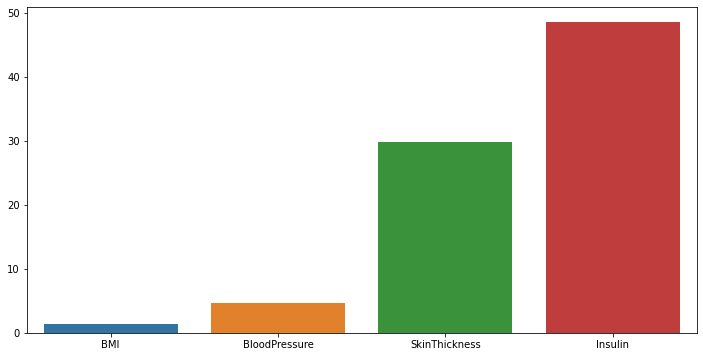

In [24]:
missing_plot(diabetes_df)

- Infant = 0-1 year.
- Toddler = 2-4 yrs.
- Child = 5-12 yrs.
- Teen = 13-19 yrs.
- Adult = 20-39 yrs.
- Middle Age Adult = 40-59 yrs.
- Senior Adult = 60+

In [27]:
np.sort(diabetes_df.Age.unique())

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72,
       81], dtype=int64)

In [28]:
def age_group(age):
    
    if(age>19 and age<=39):
        return 'Adult'
    
    elif(age>39 and age<=59):
        return 'Middle Age Adult'
    
    elif(age>=60):
        return 'Senior Adult'

In [29]:
diabetes_df['age_group'] = diabetes_df['Age'].apply(age_group)

In [30]:
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,Middle Age Adult
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,Adult
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,Adult
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Adult
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Adult
...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,Senior Adult
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0,Adult
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,Adult
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1,Middle Age Adult


In [33]:
diabetes_df['BMI'] = diabetes_df.groupby('age_group')['BMI'].apply(lambda x: x.fillna(x.mean()))

In [34]:
missing_percent(diabetes_df)

BloodPressure     4.587156
SkinThickness    29.750983
Insulin          48.492792
dtype: float64

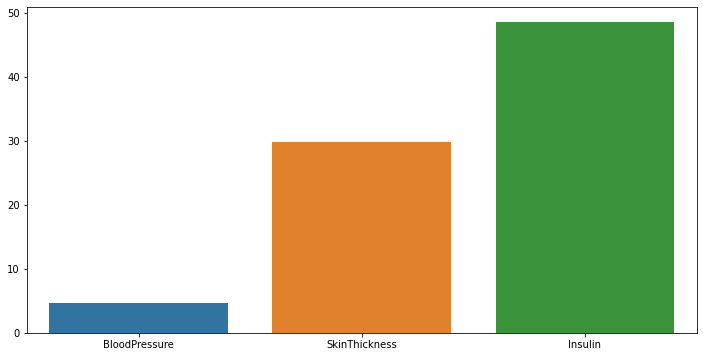

In [35]:
missing_plot(diabetes_df)

In [36]:
diabetes_df['BloodPressure'] = diabetes_df.groupby('age_group')['BloodPressure'].apply(lambda x: 
                                                                            x.fillna(x.mean()))

In [37]:
missing_percent(diabetes_df)

SkinThickness    29.750983
Insulin          48.492792
dtype: float64

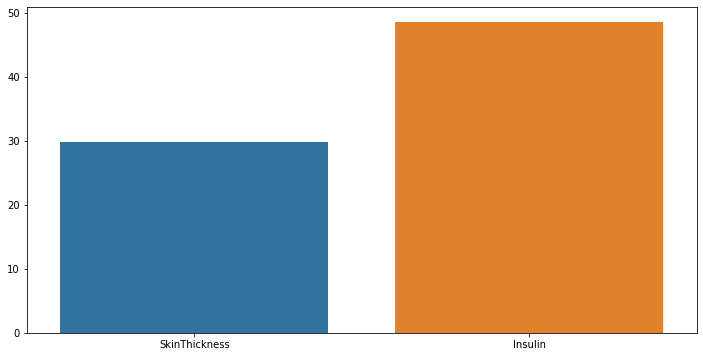

In [38]:
missing_plot(diabetes_df)

In [39]:
diabetes_df['SkinThickness'] = diabetes_df.groupby('age_group')['SkinThickness'].apply(lambda x: 
                                                                            x.fillna(x.mean()))

In [40]:
missing_percent(diabetes_df)

Insulin    48.492792
dtype: float64

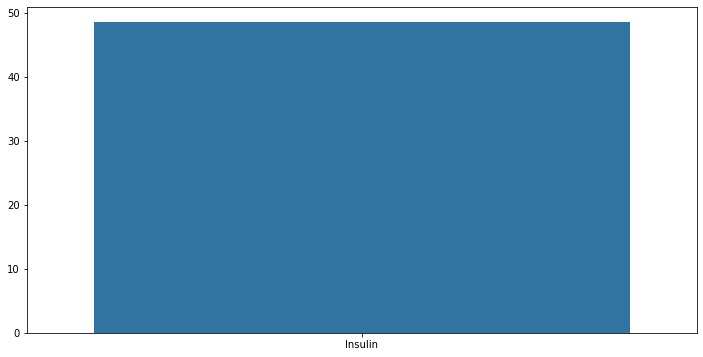

In [41]:
missing_plot(diabetes_df)

In [42]:
diabetes_df['Insulin'] = diabetes_df.groupby('age_group')['Insulin'].apply(lambda x: 
                                                                          x.fillna(x.mean()))

In [43]:
missing_percent(diabetes_df)

Series([], dtype: float64)

In [45]:
diabetes_df['Outcome'].value_counts()

0    497
1    266
Name: Outcome, dtype: int64

<AxesSubplot:xlabel='Outcome', ylabel='count'>

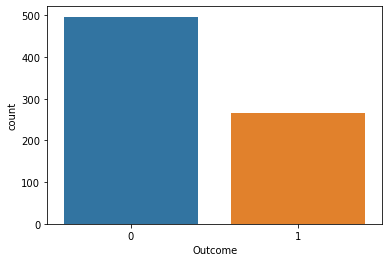

In [46]:
sns.countplot(data=diabetes_df, x='Outcome')

Here from the above visualization it is clearly visible that our dataset is completely imbalanced in fact the number of patients who are diabetic is half of the patients who are non-diabetic.

In [49]:
X = diabetes_df.drop(['Outcome', 'age_group'], axis=1)
y = diabetes_df['Outcome']

In [50]:
X.shape

(763, 8)

# 2. train test split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Feature Scaling

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Run SVM with default hyperparameters

In [59]:
def svm_model(X_train, y_train, C=1.0, kernel='rbf', degree=3, gamma='scale'):
    svm = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    svm.fit(X_train, y_train)
    return svm

In [60]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
    return y_pred

In [61]:
rbf_svm = svm_model(X_train_scaled, y_train)

In [62]:
rbf_y_pred = model_evaluation(rbf_svm, X_test_scaled, y_test)

Accuracy score: 0.7647058823529411


### Run SVM with rbf kernel and C=100.0

In [63]:
rbf_svm = svm_model(X_train_scaled, y_train, C=100)

In [64]:
rbf_y_pred = model_evaluation(rbf_svm, X_test_scaled, y_test)

Accuracy score: 0.7189542483660131


### Run SVM with rbf kernel and C=1000.0


In [67]:
rbf_svm = svm_model(X_train_scaled, y_train, C=1000)

In [68]:
rbf_y_pred = model_evaluation(rbf_svm, X_test_scaled, y_test)

Accuracy score: 0.7189542483660131


# 5. Run SVM with linear kernel


### Run SVM with linear kernel and C=1.0

In [69]:
linear_svm = svm_model(X_train_scaled, y_train, C=1.0, kernel='linear')

In [70]:
linear_y_pred = model_evaluation(linear_svm, X_test_scaled, y_test)

Accuracy score: 0.7712418300653595


### Run SVM with linear kernel and C=100.0

In [71]:
linear_svm = svm_model(X_train_scaled, y_train, C=100.0, kernel='linear')

In [72]:
linear_y_pred = model_evaluation(linear_svm, X_test_scaled, y_test)

Accuracy score: 0.7712418300653595


### Run SVM with linear kernel and C=1000.0

In [73]:
linear_svm = svm_model(X_train_scaled, y_train, C=1000.0, kernel='linear')

In [74]:
linear_y_pred = model_evaluation(linear_svm, X_test_scaled, y_test)

Accuracy score: 0.7712418300653595


### Compare the train-set and test-set accuracy


In [75]:
y_train_pred = model_evaluation(linear_svm, X_train_scaled, y_train)
y_test_pred = model_evaluation(linear_svm, X_test_scaled, y_test)

Accuracy score: 0.7688524590163934
Accuracy score: 0.7712418300653595


### Check for overfitting and underfitting

In [76]:
0.7688524590163934 - 0.7712418300653595

-0.0023893710489660824

# 6. Run SVM with polynomial kernel


### Run SVM with polynomial kernel and C=1.0

In [77]:
poly_svm = svm_model(X_train_scaled, y_train, C=1.0, kernel='poly')

In [78]:
poly_y_pred = model_evaluation(poly_svm, X_test_scaled, y_test)

Accuracy score: 0.7516339869281046


 ### Run SVM with polynomial kernel and C=100.0

In [79]:
poly_svm = svm_model(X_train_scaled, y_train, C=100.0, kernel='poly')

In [80]:
poly_y_pred = model_evaluation(poly_svm, X_test_scaled, y_test)

Accuracy score: 0.7581699346405228


# 7. Run SVM with sigmoid kernel


### Run SVM with sigmoid kernel and C=1.0

In [81]:
sigmoid_svm = svm_model(X_train_scaled, y_train, C=1.0, kernel='sigmoid')

In [82]:
sigmoid_y_pred = model_evaluation(sigmoid_svm, X_test_scaled, y_test)

Accuracy score: 0.7189542483660131


### Run SVM with sigmoid kernel and C=100.0

In [83]:
sigmoid_svm = svm_model(X_train_scaled, y_train, C=100.0, kernel='sigmoid')

In [84]:
sigmoid_y_pred = model_evaluation(sigmoid_svm, X_test_scaled, y_test)

Accuracy score: 0.6928104575163399


# 8. Confusion matrix

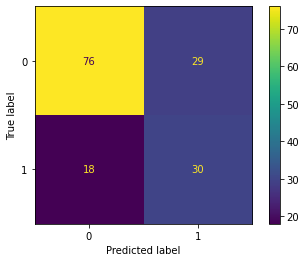

In [86]:
plot_confusion_matrix(sigmoid_svm, X_test_scaled, y_test)

# 9. Classification metrices

In [88]:
print(classification_report(y_test, sigmoid_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       105
           1       0.51      0.62      0.56        48

    accuracy                           0.69       153
   macro avg       0.66      0.67      0.66       153
weighted avg       0.71      0.69      0.70       153



# 10. k-fold Cross Validation

### k-Fold Cross Validation with shuffle split with  linear kernel

In [94]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(kernel='linear'))])

In [95]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

In [96]:
linear_scores = cross_val_score(pipe, X, y, cv=k_fold)

In [97]:
linear_scores

array([0.77124183, 0.78431373, 0.71895425, 0.75657895, 0.80921053])

In [98]:
linear_scores.mean()

0.7680598555211559

### k-Fold Cross Validation with shuffle split with rbf kernel

In [99]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(kernel='rbf'))])

In [100]:
rbf_scores = cross_val_score(pipe, X, y, cv=k_fold)

In [101]:
rbf_scores

array([0.76470588, 0.80392157, 0.74509804, 0.72368421, 0.75      ])

In [102]:
rbf_scores.mean()

0.7574819401444788

# 11. Hyperparameter Optimization using GridSearch CV

In [103]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC())])

In [104]:
parameters = [ dict(clf__C=[1, 10, 100, 1000], clf__kernel=['linear']),
               dict(clf__C=[1, 10, 100, 1000], clf__kernel=['rbf'], clf__gamma=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
               dict(clf__C=[1, 10, 100, 1000], clf__kernel=['poly'], clf__degree= [2,3,4] ,clf__gamma=[0.01,0.02,0.03,0.04,0.05]) 
              ]

In [136]:
grid_search = GridSearchCV(estimator = pipe,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=3)

In [137]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ......clf__C=1, clf__kernel=linear;, score=0.795 total time=   0.0s
[CV 2/5] END ......clf__C=1, clf__kernel=linear;, score=0.754 total time=   0.0s
[CV 3/5] END ......clf__C=1, clf__kernel=linear;, score=0.762 total time=   0.0s
[CV 4/5] END ......clf__C=1, clf__kernel=linear;, score=0.721 total time=   0.0s
[CV 5/5] END ......clf__C=1, clf__kernel=linear;, score=0.820 total time=   0.0s
[CV 1/5] END .....clf__C=10, clf__kernel=linear;, score=0.803 total time=   0.0s
[CV 2/5] END .....clf__C=10, clf__kernel=linear;, score=0.754 total time=   0.0s
[CV 3/5] END .....clf__C=10, clf__kernel=linear;, score=0.762 total time=   0.0s
[CV 4/5] END .....clf__C=10, clf__kernel=linear;, score=0.713 total time=   0.0s
[CV 5/5] END .....clf__C=10, clf__kernel=linear;, score=0.820 total time=   0.0s
[CV 1/5] END ....clf__C=100, clf__kernel=linear;, score=0.803 total time=   0.1s
[CV 2/5] END ....clf__C=100, clf__kernel=linea

[CV 5/5] END clf__C=10, clf__gamma=0.7, clf__kernel=rbf;, score=0.713 total time=   0.0s
[CV 1/5] END clf__C=10, clf__gamma=0.8, clf__kernel=rbf;, score=0.713 total time=   0.0s
[CV 2/5] END clf__C=10, clf__gamma=0.8, clf__kernel=rbf;, score=0.705 total time=   0.0s
[CV 3/5] END clf__C=10, clf__gamma=0.8, clf__kernel=rbf;, score=0.680 total time=   0.0s
[CV 4/5] END clf__C=10, clf__gamma=0.8, clf__kernel=rbf;, score=0.648 total time=   0.0s
[CV 5/5] END clf__C=10, clf__gamma=0.8, clf__kernel=rbf;, score=0.705 total time=   0.0s
[CV 1/5] END clf__C=10, clf__gamma=0.9, clf__kernel=rbf;, score=0.713 total time=   0.0s
[CV 2/5] END clf__C=10, clf__gamma=0.9, clf__kernel=rbf;, score=0.672 total time=   0.0s
[CV 3/5] END clf__C=10, clf__gamma=0.9, clf__kernel=rbf;, score=0.680 total time=   0.0s
[CV 4/5] END clf__C=10, clf__gamma=0.9, clf__kernel=rbf;, score=0.648 total time=   0.0s
[CV 5/5] END clf__C=10, clf__gamma=0.9, clf__kernel=rbf;, score=0.697 total time=   0.0s
[CV 1/5] END clf__C=1

[CV 1/5] END clf__C=1000, clf__gamma=0.8, clf__kernel=rbf;, score=0.713 total time=   0.0s
[CV 2/5] END clf__C=1000, clf__gamma=0.8, clf__kernel=rbf;, score=0.705 total time=   0.0s
[CV 3/5] END clf__C=1000, clf__gamma=0.8, clf__kernel=rbf;, score=0.680 total time=   0.0s
[CV 4/5] END clf__C=1000, clf__gamma=0.8, clf__kernel=rbf;, score=0.648 total time=   0.0s
[CV 5/5] END clf__C=1000, clf__gamma=0.8, clf__kernel=rbf;, score=0.705 total time=   0.0s
[CV 1/5] END clf__C=1000, clf__gamma=0.9, clf__kernel=rbf;, score=0.713 total time=   0.0s
[CV 2/5] END clf__C=1000, clf__gamma=0.9, clf__kernel=rbf;, score=0.672 total time=   0.0s
[CV 3/5] END clf__C=1000, clf__gamma=0.9, clf__kernel=rbf;, score=0.680 total time=   0.0s
[CV 4/5] END clf__C=1000, clf__gamma=0.9, clf__kernel=rbf;, score=0.648 total time=   0.0s
[CV 5/5] END clf__C=1000, clf__gamma=0.9, clf__kernel=rbf;, score=0.697 total time=   0.0s
[CV 1/5] END clf__C=1, clf__degree=2, clf__gamma=0.01, clf__kernel=poly;, score=0.639 tota

[CV 2/5] END clf__C=1, clf__degree=4, clf__gamma=0.05, clf__kernel=poly;, score=0.656 total time=   0.0s
[CV 3/5] END clf__C=1, clf__degree=4, clf__gamma=0.05, clf__kernel=poly;, score=0.639 total time=   0.0s
[CV 4/5] END clf__C=1, clf__degree=4, clf__gamma=0.05, clf__kernel=poly;, score=0.664 total time=   0.0s
[CV 5/5] END clf__C=1, clf__degree=4, clf__gamma=0.05, clf__kernel=poly;, score=0.664 total time=   0.0s
[CV 1/5] END clf__C=10, clf__degree=2, clf__gamma=0.01, clf__kernel=poly;, score=0.639 total time=   0.0s
[CV 2/5] END clf__C=10, clf__degree=2, clf__gamma=0.01, clf__kernel=poly;, score=0.639 total time=   0.0s
[CV 3/5] END clf__C=10, clf__degree=2, clf__gamma=0.01, clf__kernel=poly;, score=0.631 total time=   0.0s
[CV 4/5] END clf__C=10, clf__degree=2, clf__gamma=0.01, clf__kernel=poly;, score=0.656 total time=   0.0s
[CV 5/5] END clf__C=10, clf__degree=2, clf__gamma=0.01, clf__kernel=poly;, score=0.656 total time=   0.0s
[CV 1/5] END clf__C=10, clf__degree=2, clf__gamma=

[CV 1/5] END clf__C=100, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.697 total time=   0.0s
[CV 2/5] END clf__C=100, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.615 total time=   0.0s
[CV 3/5] END clf__C=100, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.631 total time=   0.0s
[CV 4/5] END clf__C=100, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.648 total time=   0.0s
[CV 5/5] END clf__C=100, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.705 total time=   0.0s
[CV 1/5] END clf__C=100, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.689 total time=   0.0s
[CV 2/5] END clf__C=100, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.615 total time=   0.0s
[CV 3/5] END clf__C=100, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.648 total time=   0.0s
[CV 4/5] END clf__C=100, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.664 total time=   0.0s
[CV 5/5] END clf__C=100, clf__degree=

[CV 4/5] END clf__C=1000, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.639 total time=   0.0s
[CV 5/5] END clf__C=1000, clf__degree=2, clf__gamma=0.02, clf__kernel=poly;, score=0.713 total time=   0.0s
[CV 1/5] END clf__C=1000, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.656 total time=   0.0s
[CV 2/5] END clf__C=1000, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.631 total time=   0.0s
[CV 3/5] END clf__C=1000, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.639 total time=   0.0s
[CV 4/5] END clf__C=1000, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.639 total time=   0.0s
[CV 5/5] END clf__C=1000, clf__degree=2, clf__gamma=0.03, clf__kernel=poly;, score=0.713 total time=   0.0s
[CV 1/5] END clf__C=1000, clf__degree=2, clf__gamma=0.04, clf__kernel=poly;, score=0.664 total time=   0.1s
[CV 2/5] END clf__C=1000, clf__degree=2, clf__gamma=0.04, clf__kernel=poly;, score=0.631 total time=   0.0s
[CV 3/5] END clf__C=1000, cl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid=[{'clf__C': [1, 10, 100, 1000],
                          'clf__kernel': ['linear']},
                         {'clf__C': [1, 10, 100, 1000],
                          'clf__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                         0.9],
                          'clf__kernel': ['rbf']},
                         {'clf__C': [1, 10, 100, 1000],
                          'clf__degree': [2, 3, 4],
                          'clf__gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'clf__kernel': ['poly']}],
             scoring='accuracy', verbose=3)

In [138]:
grid_search.best_score_

0.7704918032786885

In [139]:
grid_search.best_params_

{'clf__C': 1, 'clf__kernel': 'linear'}

In [140]:
final_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(C=1, kernel='linear'))])

In [111]:
final_pipe.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()),
                ('clf', SVC(C=1, kernel='linear'))])

In [113]:
dump(final_pipe, 'diabetes_SVM_Model.joblib')

['diabetes_SVM_Model.joblib']

In [114]:
load_svm = load('diabetes_SVM_Model.joblib')

In [124]:
sample = np.matrix(X.iloc[0].values)

In [125]:
sample

matrix([[  6.        , 148.        ,  72.        ,  35.        ,
         194.02816901,  33.6       ,   0.627     ,  50.        ]])

In [127]:
y[0]

1

In [126]:
load_svm.predict(sample)

array([1], dtype=int64)

<div class="alert alert-success" role="alert">
  <h1 class="alert-heading">Well done!</h1>
  <p>Best Wishes!, Filoger</p>
</div>